In [ ]:
import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.special import lambertw
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
ncpu = 9
cluster = ipp.Cluster(engines="mpi", n=ncpu)
client = cluster.start_and_connect_sync()
# client.shutdown()

Starting 9 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 9/9 [00:28<00:00,  3.17s/engine]


In [ ]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
print("Rank {} of {} is alive".format(rank, size))

[stdout:0] Rank 0 of 9 is alive


[stdout:6] Rank 6 of 9 is alive


[stdout:4] Rank 4 of 9 is alive


[stdout:3] Rank 3 of 9 is alive


[stdout:2] Rank 2 of 9 is alive


[stdout:5] Rank 5 of 9 is alive


[stdout:1] Rank 1 of 9 is alive


[stdout:8] Rank 8 of 9 is alive


[stdout:7] Rank 7 of 9 is alive


In [ ]:
client.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%px
nxsub = 300
nysub = 300
import numpy as np
sectsY = int(np.floor(np.sqrt(size)))
sectsX = int(size/sectsY)
if rank == 0: print('In the case of equal size we divide the processes as {} and {}'.format(sectsX, sectsY))
grid_x = nxsub // sectsX + 2
grid_y = nysub // sectsY + 2
lattice = np.ones((grid_x, grid_y))

[stdout:0] In the case of equal size we divide the processes as 3 and 3


In [ ]:
%%px

cartcomm = comm.Create_cart(dims=[sectsX, sectsY], periods=[False, False], reorder=False)
rcoords = cartcomm.Get_coords(rank)

# where to receive from and where send to
sR, dR = cartcomm.Shift(1, 1)
sL, dL = cartcomm.Shift(1, -1)
sU, dU = cartcomm.Shift(0, -1)
sD, dD = cartcomm.Shift(0, 1)

# sR, dR = cartcomm.Shift(0, 1)
# sL, dL = cartcomm.Shift(0, -1)
# sU, dU = cartcomm.Shift(1, 1)
# sD, dD = cartcomm.Shift(1, -1)

sd = np.array([sR, dR, sL, dL, sU, dU, sD, dD], dtype = int)

# Analysis of the domain
allrcoords = comm.gather(rcoords, root = 0)
allDestSourBuf = np.zeros(size * 8, dtype = int)
comm.Gather(sd, allDestSourBuf, root = 0)

# print(sd)

if rank == 0:
    # print(' ')
    cartarray = np.ones((sectsY, sectsX), dtype=int)
    allDestSour = np.array(allDestSourBuf).reshape((size, 8))

    for i in np.arange(size):

        cartarray[allrcoords[i][0], allrcoords[i][1]] = i
        # print('Rank {} all destinations and sources {}'.format(i, allDestSour[i, :]))

        sR, dR, sL, dL, sU, dU, sD, dD = allDestSour[i]

        print('Rank {} is at {}'.format(i, allrcoords[i]))
        print('sour/dest right {} {}'.format(sR,dR))
        print('sour/dest left  {} {}'.format(sL,dL))
        print('sour/dest up    {} {}'.format(sU,dU))
        print('sour/dest down  {} {}'.format(sD,dD))
        print('[stdout:', i, ']', allDestSour[i])

    # print(' ')
    # print(cartarray)

[stdout:0] Rank 0 is at [0, 0]
sour/dest right -1 1
sour/dest left  1 -1
sour/dest up    3 -1
sour/dest down  -1 3
[stdout: 0 ] [-1  1  1 -1  3 -1 -1  3]
Rank 1 is at [0, 1]
sour/dest right 0 2
sour/dest left  2 0
sour/dest up    4 -1
sour/dest down  -1 4
[stdout: 1 ] [ 0  2  2  0  4 -1 -1  4]
Rank 2 is at [0, 2]
sour/dest right 1 -1
sour/dest left  -1 1
sour/dest up    5 -1
sour/dest down  -1 5
[stdout: 2 ] [ 1 -1 -1  1  5 -1 -1  5]
Rank 3 is at [1, 0]
sour/dest right -1 4
sour/dest left  4 -1
sour/dest up    6 0
sour/dest down  0 6
[stdout: 3 ] [-1  4  4 -1  6  0  0  6]
Rank 4 is at [1, 1]
sour/dest right 3 5
sour/dest left  5 3
sour/dest up    7 1
sour/dest down  1 7
[stdout: 4 ] [3 5 5 3 7 1 1 7]
Rank 5 is at [1, 2]
sour/dest right 4 -1
sour/dest left  -1 4
sour/dest up    8 2
sour/dest down  2 8
[stdout: 5 ] [ 4 -1 -1  4  8  2  2  8]
Rank 6 is at [2, 0]
sour/dest right -1 7
sour/dest left  7 -1
sour/dest up    -1 3
sour/dest down  3 -1
[stdout: 6 ] [-1  7  7 -1 -1  3  3 -1]
Rank 7

In [ ]:
%%px

def Communicate(c, cartcomm, sd):

    sR, dR, sL, dL, sU, dU, sD, dD = sd

    '''Send to left and receive from right'''
    sendbuf = np.ascontiguousarray(c[:, :, 1])
    recvbuf = c[:, :, -1].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf, dest=dL, recvbuf=recvbuf, source=sL)
    c[:, :, -1] = recvbuf
    ''''''

    '''Send to right which is destination right (dR) and receive from left which is source right (sR)'''
    sendbuf = np.ascontiguousarray(c[:, :, -2]) # Send the second last column to dR
    recvbuf = c[:, :, 0].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf, dest=dR, recvbuf=recvbuf, source=sR)
    c[:, :, 0] = recvbuf # received into the 0th column from sR
    ''''''

    '''Send to down and receive from up'''
    sendbuf = np.ascontiguousarray(c[:, -2, :])
    recvbuf = c[:, 0, :].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf, dest=dD, recvbuf=recvbuf, source=sD)
    c[:, 0, :] = recvbuf
    ''''''

    '''Send to up and receive from down'''
    sendbuf = np.ascontiguousarray(c[:, 1, :])
    recvbuf = c[:, -1, :].copy()
    cartcomm.Sendrecv(sendbuf=sendbuf, dest=dU, recvbuf=recvbuf, source=sU)
    c[:, -1, :] = recvbuf
    ''''''

    return c

def streaming_operator(f_inm, c_ai):

    '''streaming'''
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift=c_ai.T[i], axis=(0, 1))
    ''''''
    return f_inm

def feq(rho_nm, u_anm, c_ai, w_i):

    '''c * u'''
    cu_nm = np.einsum('ai,anm->inm', c_ai, u_anm)
    ''''''

    '''squaring cu'''
    sqcu_nm = cu_nm**2
    ''''''

    '''scalar product of the velocity vectors with itself at each lattice side'''
    usq_nm = np.einsum('anm,anm->nm', u_anm, u_anm)
    ''''''

    '''equilibrium distribution'''
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    ''''''

    '''calculating equivalent probability density function'''
    feq_inm = wrho_inm * (1 + 3 * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm)
    ''''''

    return feq_inm

def collision(f_inm, c_ai, w_i, omega):

    '''calculating density from pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    ''''''

    '''calculating average velocity'''
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm) / rho_nm
    ''''''

    '''calculating equilibrium probability density function'''
    feq_ixy = feq(rho_nm, u_anm, c_ai, w_i)
    ''''''

    return (f_inm + (omega * (feq_ixy - f_inm))), u_anm

def boundary_conditions(f_inm, rho_nm, c_ai, w_i, grid_x, grid_y, boundary):

    c_s = 1/math.sqrt(3)

    '''index_rigid stores directions'''
    index_south = np.array([4, 7, 8])
    index_north = np.array([2, 5, 6])
    index_west = np.array([3, 6, 7])
    index_east = np.array([1, 8, 5])
    ''''''

    '''wall velocity,an array of shape (2,)'''
    u_w = np.array([0, 0.1])
    ''''''

    '''calculating average value of density matrix'''
    total = 0
    for i in rho_nm:
        for j in i:
            total = total + j
    rho_average = total/(rho_nm.size)
    ''''''

    '''copying probability density function to a dummy variable'''
    f_inm_dummy = np.empty_like(f_inm)
    for i in range(9):
        for j in range(grid_x):
            for k in range(grid_y):
                f_inm_dummy[i, j, k] = f_inm[i, j, k]
    ''''''

    '''performing an inital streaming operation to update the probability density function'''
    f_inm = streaming_operator(f_inm, c_ai)
    ''''''

    for i in range(9):
        '''checking if we are at the south boundary and applying rigid wall'''
        if boundary[2] == True:
            if i in index_south:
                f_inm[index_north[np.where(i == index_south)[0][0]], -1, :] = f_inm_dummy[i, -1, :]

        '''checking if we are at the west boundary and applying rigid wall'''
        if boundary[0] == True:
            if i in index_west:
                '''applying rigid wall at the west boundary'''
                f_inm[index_east[np.where(i == index_west)[0][0]], :, 0] = f_inm_dummy[i, :, 0]

        '''checking if we are at the east boundary and applying rigid wall'''
        if boundary[1] == True:
            if i in index_east:
                '''applying rigid wall at the east boundary'''
                f_inm[index_west[np.where(i == index_east)[0][0]], :, -1] = f_inm_dummy[i, :, -1]

        '''checking if we are at the south boundary and applying rigid wall'''
        if boundary[3] == True:
            if i in index_north:
                '''applying moving wall at the north boundary'''
                f_inm[index_south[np.where(i == index_north)[0][0]], 0, :] = f_inm_dummy[i, 0, :] - 2 * w_i[i] * rho_average * ((c_ai[:, i] @ u_w).T / (c_s ** 2))


    '''Calulating density and velocity using pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm)

    ''''''
    return f_inm, rho_nm, u_anm, rho_average

time_steps = 100000
omega = 1.3
epsilon = 0.1
wall_velocity = 0.3
viscosity = 1/3 * ((1/omega) - 0.5)
L = 300

'''setting up initial density values'''
rho_nm = np.ones((grid_x, grid_y))
''''''

'''setting up initial velocity values'''
u_anm = np.zeros((2, grid_x, grid_y))
''''''

'''setting up weights'''
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
''''''

c_ai = np.array([[ 0,  0, -1,  0,  1, -1, -1,  1,  1],
                 [ 0,  1,  0, -1,  0,  1, -1, -1,  1]])

velocity_field = np.empty((2, grid_x-2, grid_y-2))
c = np.stack((velocity_field, u_anm[:, 1:-1, 1:-1]), axis=0)

boundary = [False, False, False, False] # [Left, Right, Down, Up].

if rcoords[1] == 0: boundary[0] = True # if True then there is a boundary to the left of this subdomain.
if rcoords[1] == sectsY-1: boundary[1] = True # if True then there is a boundary to the right of this subdomain.

if rcoords[0] == 0: boundary[3] = True # if True then there is a boundary to the top of this subdomain
if rcoords[0] == sectsX-1: boundary[2] = True # if True then there is a boundary to the bottom of this subdomain

import math

'''calculating initial equilibrium pdf'''
f_inm = feq(rho_nm, u_anm, c_ai, w_i)
''''''

'''calculating initial pdf after collision'''
f_inm, u_anm = collision(f_inm, c_ai, w_i, omega)
''''''

'''Deriving average density and velocity after collision'''
rho_nm = np.einsum('ijk -> jk', f_inm)
''''''

f_inm = Communicate(f_inm, cartcomm, sd)

'''applying boundary conditions'''
f_inm, rho_nm, u_anm, rho_average = boundary_conditions(f_inm, rho_nm, c_ai, w_i, grid_x, grid_y, boundary)
''''''

for i in range(time_steps):

    '''calculating subsequent collision pdf'''
    f_inm, u_anm = collision(f_inm, c_ai, w_i, omega)
    ''''''

    '''Deriving density matrix after collision'''
    rho_nm = np.einsum('ijk -> jk', f_inm)
    ''''''

    '''communicate'''
    f_inm = Communicate(f_inm, cartcomm, sd)
    ''''''

    '''applying boundary conditions'''
    f_inm, rho_nm, u_anm, rho_average = boundary_conditions(f_inm, rho_nm, c_ai, w_i, grid_x, grid_y, boundary)
    ''''''

    if i % 1000 == 0:
        c = np.stack((velocity_field, u_anm[:, 1:-1, 1:-1]), axis=0)

%px: 100%|██████████| 9/9 [4:51:29<00:00, 1943.29s/tasks]


In [ ]:
%%px

def save_mpiio(comm, fn, g_kl):
    """
    Write a global two-dimensional array to a single file in the npy format
    using MPI I/O: https://docs.scipy.org/doc/numpy/neps/npy-format.html

    Arrays written with this function can be read with numpy.load.

    Parameters
    ----------
    comm
        MPI communicator.
    fn : str
        File name.
    g_kl : array_like
        Portion of the array on this MPI processes. This needs to be a
        two-dimensional array.
    """
    from numpy.lib.format import dtype_to_descr, magic
    magic_str = magic(1, 0)

    local_nx, local_ny = g_kl.shape
    nx = np.empty_like(local_nx)
    ny = np.empty_like(local_ny)

    commx = comm.Sub((True, False))
    commy = comm.Sub((False, True))
    commx.Allreduce(np.asarray(local_nx), nx)
    commy.Allreduce(np.asarray(local_ny), ny)

    arr_dict_str = str({ 'descr': dtype_to_descr(g_kl.dtype),
                         'fortran_order': False,
                         'shape': (nx.item(), nx.item())
                         })
    while (len(arr_dict_str) + len(magic_str) + 2) % 16 != 15:
        arr_dict_str += ' '
    arr_dict_str += '\n'
    header_len = len(arr_dict_str) + len(magic_str) + 2

    offsetx = np.zeros_like(local_nx)
    commx.Exscan(np.asarray(ny*local_nx), offsetx)
    offsety = np.zeros_like(local_ny)
    commy.Exscan(np.asarray(local_ny), offsety)

    file = MPI.File.Open(comm, fn, MPI.MODE_CREATE | MPI.MODE_WRONLY)
    if comm.Get_rank() == 0:
        file.Write(magic_str)
        file.Write(np.int16(len(arr_dict_str)))
        file.Write(arr_dict_str.encode('latin-1'))
    mpitype = MPI._typedict[g_kl.dtype.char]
    filetype = mpitype.Create_vector(g_kl.shape[0], g_kl.shape[1], ny)
    filetype.Commit()
    file.Set_view(header_len + (offsety+offsetx)*mpitype.Get_size(),
                  filetype=filetype)
    file.Write_all(g_kl.copy())
    filetype.Free()
    file.Close()

save_mpiio(cartcomm, 'ux.npy', c[-1, 0])
save_mpiio(cartcomm, 'uy.npy', c[-1, 1])


%px: 100%|██████████| 9/9 [00:00<00:00, 20.62tasks/s]


%px:  89%|████████▉ | 8/9 [00:00<00:00, 70.80tasks/s]

[output:0]

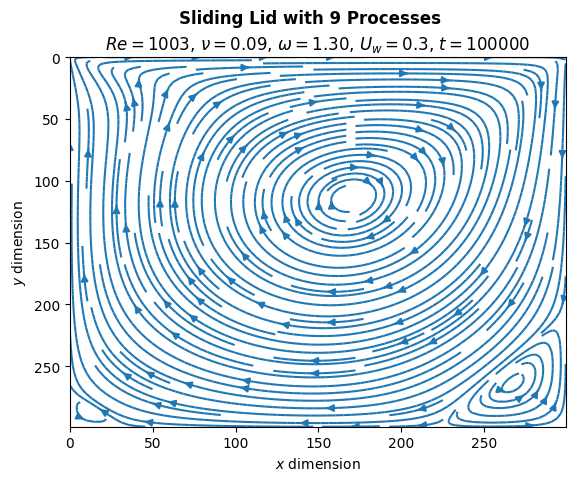

%px: 100%|██████████| 9/9 [00:03<00:00,  2.74tasks/s]


In [ ]:
%%px

L = nxsub
viscosity = 1/3 * ((1/omega) - 0.5)
Re = nxsub * wall_velocity / viscosity
omega = 1 / (3*viscosity + 0.5)

if rank == 0:
    fig, ax = plt.subplots()
    ax.set_xlim(0, L-1)
    ax.set_ylim(0, L-1)
    ax.invert_yaxis()
    ax.set_title(f"\n$Re={round(Re)}$, $\\nu={viscosity:.2f}$, $\omega={omega:.2f}$, $U_w={wall_velocity}$, $t={time_steps}$")
    ax.set_ylabel("$y$ dimension")
    ax.set_xlabel("$x$ dimension")
    x = np.arange(L)
    y = np.arange(L)

    plt.suptitle("Sliding Lid with 9 Processes", fontweight="bold")
    u = np.load('ux.npy')
    v = np.load('uy.npy')

    norm = plt.Normalize(0, wall_velocity)
    ax.streamplot(x, y, v, u,
                norm=norm,
                density=2.0)

    plt.show()